# simple sequence-to-sequence model with dynamic unrolling
https://github.com/ematvey/tensorflow-seq2seq-tutorials
![](../data/1-seq2seq.png)
Rectangles are encoder and decoder's recurrent layers. Encoder receives [A, B, C] sequence as inputs. We don't care about encoder outputs, only about the hidden state it accumulates while reading the sequence. After input sequence ends, encoder passes its final state to decoder, which receives [<EOS>, W, X, Y, Z] and is trained to output [W, X, Y, Z, <EOS>]. <EOS> token is a special word in vocabulary that signals to decoder the beginning of translation.

In [1]:
import helpers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = next(helpers.random_sequences(1,3,1,9,3))
print(x)

[[8, 6], [1, 6, 3], [8, 7]]


In [3]:
xt, xlen = helpers.batch(x)
print(xt)
print(xlen)

[[8 1 8]
 [6 6 7]
 [0 3 0]]
[2, 3, 2]


In [4]:
tf.reset_default_graph()
sess= tf.InteractiveSession()
tf.__version__

'1.3.0'

In [5]:
PAD = 0
EOS =1

vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

* encoder_inputs int32 tensor is shaped [encoder_max_time, batch_size]
* decoder_targets int32 tensor is shaped [decoder_max_time, batch_size]
* decoder_inputs int32 tensor is shaped [decoder_max_time, batch_size]

In [6]:
encoder_inputs = tf.placeholder(shape=[None, None], dtype=tf.int32, name="encoder_inputs")
decoder_inputs = tf.placeholder(shape=[None, None], dtype=tf.int32, name="decoder_inputs")
decoder_targets = tf.placeholder(shape=[None, None], dtype=tf.int32, name="decoder_targets")

In [7]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [8]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_inputs_embedded, 
                                                         dtype=tf.float32, time_major=True)

In [9]:
encoder_outputs

<tf.Tensor 'rnn/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [11]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_cell, decoder_inputs_embedded,initial_state=encoder_final_state,
                                                        dtype=tf.float32, time_major=True, scope="decoder_rnn")

In [12]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits,2)

In [13]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 10) dtype=float32>

In [14]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=decoder_logits, 
                                                                 labels=tf.one_hot(decoder_targets,vocab_size))
loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
batch_ = [[6], [3, 4], [9, 8, 7]]
batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
                 feed_dict={encoder_inputs: batch_,decoder_inputs: din_,})
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[8 8 6]
 [1 2 2]
 [5 2 2]
 [5 2 2]]


In [19]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[9, 7, 5, 8, 3, 7]
[9, 6, 5]
[7, 2, 8, 3, 5, 4, 5, 5]
[6, 7, 6]
[8, 5, 3, 2, 7]
[2, 6, 8, 6, 4]
[6, 8, 2, 4, 5, 9, 2]
[6, 5, 3, 4, 5, 6]
[8, 3, 6, 3, 2, 4]
[9, 3, 8, 5, 2]


In [23]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch([(sequence)+[EOS] for sequence in batch])
    decoder_inputs_, _ = helpers.batch([[EOS]+(sequence) for sequence in batch])
    return{
        encoder_inputs:encoder_inputs_,
        decoder_targets:decoder_targets_,
        decoder_inputs:decoder_inputs_
    }

In [25]:
loss_track=[]
max_batches = 3001
batches_in_epoch=1000
try:
    for batch in range(max_batches):
        fd = next_feed()
        _,l = sess.run([train_op,loss], feed_dict=fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(l))
            predict_ = sess.run(decoder_prediction, feed_dict=fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
            
except KeyboardInterrupt:
    print("Training interrupted!")

batch 0
  minibatch loss: 2.2783029079437256
  sample 1:
    input     > [2 6 9 9 3 0 0 0]
    predicted > [8 1 1 7 7 2 2 3 5]
  sample 2:
    input     > [8 7 4 8 2 2 0 0]
    predicted > [8 8 8 8 8 5 1 0 1]
  sample 3:
    input     > [2 5 6 6 4 9 8 2]
    predicted > [7 3 6 8 8 8 7 7 5]

batch 1000
  minibatch loss: 0.3065749406814575
  sample 1:
    input     > [5 4 9 7 5 0 0 0]
    predicted > [5 4 9 7 5 1 0 0 0]
  sample 2:
    input     > [6 7 6 0 0 0 0 0]
    predicted > [6 7 6 1 0 0 0 0 0]
  sample 3:
    input     > [5 7 3 0 0 0 0 0]
    predicted > [5 7 3 1 0 0 0 0 0]

batch 2000
  minibatch loss: 0.13055957853794098
  sample 1:
    input     > [7 7 7 0 0 0 0 0]
    predicted > [7 7 7 1 0 0 0 0 0]
  sample 2:
    input     > [3 9 4 2 0 0 0 0]
    predicted > [3 9 4 2 1 0 0 0 0]
  sample 3:
    input     > [4 4 3 4 8 8 2 6]
    predicted > [4 4 3 8 8 8 2 6 1]

batch 3000
  minibatch loss: 0.09812162816524506
  sample 1:
    input     > [3 4 4 2 3 2 5 7]
    predicted > [3 4 4

loss 0.0981 after 300100 examples (batch_size=100)


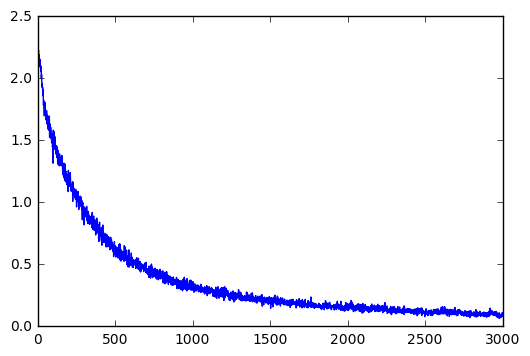

In [26]:
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))